# Attention Y-Net for mitochondria segmentation in 2D

**Note:** 

Once you have your dataset ready, you can run every cell of this notebook.

You only need to adapt as you want the values in the Parameters section.

The data to be used must be organized as follows:
for each dataset (Lucchi++, VNC, ...)
```
data/
    |-- train/
    |    |-- x/
    |    |      training-0001.tif
    |    |      ...
    |    |-- y/
    |    |      training_groundtruth-0001.tif
    |    |        ...
    |-- test/
    |    |-- x/
    |    |      testing-0001.tif
    |    |      ...
    |    |-- y/
    |    |      testing_groundtruth-0001.tif
    |    |      ...

```

## Getting started
First, we check the version of Tensorflow and set the seeds for reproducibility.

In [2]:
import tensorflow as tf
import numpy as np
import os
import random

def set_seed(seedValue=42):
  """
  Sets the seed on multiple python modules to obtain results as
  reproducible as possible.

  Args:
    seedValue (int, optional): seed value.
  """
  np.random.seed(seed=seedValue)
  tf.random.set_seed(seedValue)
  os.environ["PYTHONHASHSEED"]=str(seedValue)
  random.seed(seedValue)
set_seed()

print( tf.__version__ )

2.7.0


## Utilities 
(functions and classes)

### Load data functions

In [4]:
import os
from skimage.util import img_as_ubyte
from skimage import io
from matplotlib import pyplot as plt
from glob import glob
import shutil

def get_xy_image_list(dir):
    '''
    Reads the training images and labels from the specified directory.
    Where 'dir'/x/ contains all images, and 'dir'/y/ contains all labels.
    Image and labels will be sorted by filename
    
    Args:
      dir (str): The directory where the images are stored
    
    Returns:
      two lists, one containing the training images and the other containing the corresponding labels.
    '''
    if dir[-1]=='/':
        dir = dir[:-1]
    # Paths to the training images and their corresponding labels
    train_input_path = dir + '/x/*.*'
    train_label_path = dir + '/y/*.*'

    # Read the list of file names
    train_input_filenames = glob(train_input_path)
    train_input_filenames.sort()

    train_label_filenames = glob(train_label_path)
    train_label_filenames.sort()

    print( 'Input images loaded: {} -- Label images loaded: {}\n\tpath: {}'.format(len(train_input_filenames), len(train_label_filenames), dir) )

    # read training images and labels
    train_img = [ img_as_ubyte( np.array(io.imread( x ), dtype='uint8') ) for x in train_input_filenames ]
    train_lbl = [ img_as_ubyte( np.array(io.imread( x ), dtype='uint8') ) for x in train_label_filenames ]
    
    return train_img, train_lbl

def get_image_list(dir):
    '''
    Reads all the images in the specified directory and returns a list of numpy arrays representing the
    images
    
    Args:
      dir: The directory that contains the images.
    
    Returns:
      A list of numpy arrays representing the images.
    '''
    if dir[-1]=='/':
        dir = dir[:-1]
    train_label_path = dir + '/*.*'

    train_label_filenames = glob(train_label_path)
    train_label_filenames.sort()

    print( 'Label images loaded: ' + str( len(train_label_filenames)) )

    # read training images and labels
    train_lbl = [ img_as_ubyte( np.array(io.imread( x ), dtype='uint8') ) for x in train_label_filenames ]
    return train_lbl

def create_patches( imgs, num_x_patches, num_y_patches ):
    '''
    Create a list of image patches out of a list of images
    
    Args:
      imgs: list of input images
      num_x_patches: the number of patches in the X axis
      num_y_patches: the number of patches in the Y axis
    
    Returns:
      A list of patches.
    '''
    original_size = imgs[0].shape
    patch_width = original_size[ 0 ] // num_y_patches
    patch_height = original_size[ 1 ] // num_x_patches
    
    patches = []
    for n in range( 0, len( imgs ) ):
        image = imgs[ n ]
        for i in range( 0, num_y_patches ):
            for j in range( 0, num_x_patches ):
                patches.append( image[ i * patch_width : (i+1) * patch_width,
                                      j * patch_height : (j+1) * patch_height ] )
    return patches

# We define a method to create an arbitrary number of random crops of
# a given size
def create_random_patches( input_imgs, lbl_imgs, num_patches,
                          shape ):
    ''' 
    Create a list of images patches out of a list of images
    
    Args:
        input_imgs: list of input images
        lbl_imgs: list of input images
        num_patches (int): number of patches for each image.
        shape (2D array): size of the LR patches. Example: [128, 128].
        
    Returns:
        list of image patches and patches of corresponding labels
    '''

    # read training images
    img = input_imgs[0]

    original_size = img.shape
    
    input_patches = []
    label_patches = []
    for n in range( 0, len( input_imgs ) ):
        img = input_imgs[n]
        lbl = lbl_imgs[n]
        for i in range( num_patches ):
          r = np.random.randint(0,original_size[0]-shape[0])
          c = np.random.randint(0,original_size[1]-shape[1])
          input_patches.append(  img[ r : r + shape[0],
                                  c : c + shape[1] ] )
          label_patches.append( lbl[ r : r + shape[0],
                                  c : c + shape[1] ] )
    return input_patches, label_patches

In [5]:
from PIL import Image

def add_padding(np_img):
    '''
    Given a numpy array, add padding to the image so that the image is a multiple of 256x256
    
    Args:
      np_img: the image to be padded
    
    Returns:
      A numpy array of the image with the padding added.
    '''

    image = Image.fromarray(np_img)
    height, width = np_img.shape

    if not width%256 and not height%256:
        return np_img
    
    x = width/256
    y = height/256

    new_width = int(np.ceil(x))*256
    new_height = int(np.ceil(y))*256

    left = int( (new_width - width)/2 )
    top = int( (new_height - height)/2 )
    
    result = Image.new(image.mode, (new_width, new_height), 0)
    
    result.paste(image, (left, top))

    return np.asarray(result)

def remove_padding(np_img, out_shape):
    '''
    Given an image and the shape of the original image, remove the padding from the image
    
    Args:
      np_img: the image to remove padding from
      out_shape (int,int): the desired shape of the output image (height, width)
    
    Returns:
      The image with the padding removed.
    '''

    height, width = out_shape # original dimensions
    pad_height, pad_width = np_img.shape # dimensions with padding

    if not width%256 and not height%256: # no hacia falta padding --> no tiene
        return np_img
    
    rm_left = int( (pad_width - width)/2 )
    rm_top = int( (pad_height - height)/2 )

    rm_right = pad_width - width - rm_left
    rm_bot = pad_height - height - rm_top

    return np.array(np_img[rm_top:-rm_bot, rm_left:-rm_right])

### Histogram matching

In [6]:
# apply histogram matching to any image (not mask) from sorce dataset, using target mean histogram
# this histogram matching, match the given cumulative histogram to target cumulative histogram
from sklearn.linear_model import LinearRegression

def histogram_matching(target_imgs, apply_prob):
    '''
    Given a set of images, it will obtain their mean histogram. The number of 0s of this histogram will be predicted
     using Linear regression, with the real number of 1 and 2. It returns a function that apply histogram matching,
     using the calculated histogram. This returned function will apply a random histogram matching to each image with probability
     apply_prob.
    
    Args:
      target_imgs: the target domain images, from which mean histogram will be obtained (with predicted number of 0s)
      apply_prob: probability of applying the histogram matching
    
    Returns:
      A function that takes an image as input and returns a modified image or the original image, with
    the given probability.
    '''

    LR = LinearRegression()
    hist_mean,_ = np.histogram(np.array(target_imgs).ravel(), bins=np.arange(256))
    reg = LR.fit(np.reshape([1,2],(-1,1)), np.reshape(hist_mean[1:3],(-1,1))) # use next 2 values to predict using LR
    hist_mean[0] = max(0, float(reg.predict(np.reshape([0,],(-1,1))))) # predict 0 values (due to padding)
    hist_mean = hist_mean / np.array(target_imgs).shape[0] # number of images
    
    # calculate normalized quantiles
    #tmpl_size = target_imgs[0].size # once 0 value is predicted, the sum of pixels are not the same as the one in the image, so size is no longer useful
    tmpl_size = np.sum(hist_mean) 
    tmpl_quantiles = np.cumsum(hist_mean) / tmpl_size
    
    # based on scikit implementation. 
    # source: https://github.com/scikit-image/scikit-image/blob/v0.18.0/skimage/exposure/histogram_matching.py#L22-L70
    def _match_cumulative_cdf(source, tmpl_quantiles):
        src_values, src_unique_indices, src_counts = np.unique(source.ravel(),
                                                            return_inverse=True,
                                                            return_counts=True)

        # calculate normalized quantiles
        # replace number of 0s with lineal regression in order to avoid padding
        if src_values[0] == 0:
            if src_values[:3].tolist() == [0,1,2]:
                reg = LR.fit(np.reshape([1,2],(-1,1)), np.reshape(src_counts[1:3],(-1,1))) # use next 2 values to predict using LR
                pred_0 = max( 0, float(reg.predict(np.reshape([0,],(-1,1)))) ) # predict 0 values (due to padding)
            else:
                # images can be completely black
                pred_0 = 1 if len(src_counts) == 1 else 0 # 1 if completely black, else 0
           
            src_size = (source.size - src_counts[0]) + pred_0 # more efficient than 'sum(src_counts)'
            src_counts[0] = pred_0 # replace histogram 0s with predictted value
        else:
            src_size = source.size # number of pixels
        
        src_quantiles = np.cumsum(src_counts) / src_size # normalize
        interp_a_values = np.interp(src_quantiles, tmpl_quantiles, np.arange(len(tmpl_quantiles)))
        if src_values[0] == 0:
            interp_a_values[0] = 0 # we want to keep 0s, (padding)

        return interp_a_values[src_unique_indices].reshape(source.shape)

    def random_histogram_matching(image):
        if random.random() < apply_prob:
            result = _match_cumulative_cdf(image, tmpl_quantiles)
        else:
            result = image
        return result
    
    return random_histogram_matching

def cond_hist_match(apply, target_img, apply_prob = 0.5):
    '''
    If apply is True, then it will return the histogram_matching function, otherwise it will return the
    do_nothing function
    
    Args:
      apply (bool): Whether to apply the transformation or not
      target_img: List of target domain images (from which mean histogram will be obtained)
      apply_prob: The probability of applying the histogram matching
    
    Returns:
      A function that takes an image as input and returns the image with the histogram matched (with given probability) 
      or the image itself if apply == False.
    '''

    def do_nothing(image):
        return image

    if apply:
        return histogram_matching(target_img, apply_prob)
    else:
        return do_nothing

In [7]:
def filter_patches(img_list, lbl_list, zeros_perc = 0.5):
    '''
    Given a list of images and labels, it filters out the images that have more than x% of zeros in
    them.
    
    Args:
      img_list: list of images
      lbl_list: list of labels
      zeros_perc: the percentage of zeros in the image that we want to filter out
    
    Returns:
      two lists, one with the filtered images and the other with their labels.
    '''
    
    resul_img_list = []
    resul_lbl_list = []
    for img, lbl in zip(img_list, lbl_list):
        img_hist,_ = np.histogram(np.array(img).ravel(), bins=np.arange(256))
        if img_hist[0]/np.sum(img_hist) < zeros_perc:
            resul_img_list.append(img)
            resul_lbl_list.append(lbl)
    return resul_img_list, resul_lbl_list

### ARA

In [8]:
import statistics
import os
import sys
import datetime
import numpy as np
from PIL import Image
from skimage.measure import label, regionprops_table
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import keras

def morphology_analysis(data, input, delta):
    '''
    The function morphology_analysis returns the mean and median of the area, solidity,
    eccentricity, orientation and number of objects
    
    Args:
      data: List of labels (binary masks)
      input: List of images associated with the masks
      delta: This value will be added to the factor (initially 1) by which the ratio (ARA) of the image is multiplied.
    
    Returns:
      The function morphology_analysis returns the mean of the area (and median, only in this case), solidity,
    eccentricity, orientation and number of objects. It returns also the ratio (ARA) value
    '''

    p_area = []
    p_solidity = []
    p_eccentricity = []
    p_orientation = []
    n_objects=[]
    ratio_objects_area=[]
    pixels_to_th= 10 
    factor = 1

    label_img = label(data)   # Connected components 

    for i in range(label_img.shape[0]):     # Por cada imagen 2D
        
        img = label_img[i]
        area=(label_img.shape[1] * label_img.shape[2])
        if delta != 0.0:
            area = area - np.sum(np.sum((input[i]==0))) 

        props = regionprops_table(img, properties=('area', 'solidity', 'eccentricity', 'orientation'))    # Sacar las propiedades

        for v in props['area']: 
            p_area.append(v)
            ratio = v/area
            ratio = ratio*factor
            if v>pixels_to_th:
                ratio_objects_area.append(ratio)      
        factor = factor + delta

        for v in props['solidity']: p_solidity.append(v)
        for v in props['eccentricity']: p_eccentricity.append(v)
        for v in props['orientation']: p_orientation.append(v)  
        n_objects.append(len(np.unique(img))-1) 

    try:
        gt_area_value = statistics.mean(p_area)
        gt_solidity_value = statistics.mean(p_solidity)
        gt_eccentricity_value = statistics.mean(p_eccentricity)
        gt_orientation_value = statistics.mean(p_orientation) 
        gt_area_value_median=statistics.median(p_area)
        gt_object_number=statistics.mean(n_objects)
        gt_ratio=statistics.mean(ratio_objects_area)
        
    except:
        gt_area_value = 0
        gt_solidity_value = 0
        gt_eccentricity_value = 0
        gt_orientation_value = 0
        gt_area_value_median=0
        gt_object_number=0
        gt_ratio=0

    return gt_area_value,gt_solidity_value,gt_eccentricity_value,gt_orientation_value,gt_area_value_median,gt_object_number,gt_ratio

In [9]:
from copy import copy
# Used to obtain the model using ARA
class CustomSaver(keras.callbacks.Callback):
    def __init__(self, src_data_path, data_path, source, target, analysis_mode, path_save='ARA_tmp_Models'):
        '''
        Args:
          src_data_path: the path to the source dataset
          data_path: the path to the target dataset
          source: the name of source dataset
          target: the name of target dataset.
          analysis_mode: Plots and csv files will be generated and stored with several obtained values
          path_save: the path where the model will be saved, defaults to ARA_tmp_Models (optional). Defaults to
        Models
        '''
        def prepare_data(list_img, list_lbl, use_padding, expand_dims):
            '''
            Given a list of images and labels, it will normalize the images between 0 and 1, and add padding if
            specified
            
            Args:
              list_img: list of images
              list_lbl: list of labels
              use_padding: If True, add padding to the images (height and width multiple of 256).
              expand_dims: If True, expand the dimensions of the images to add an extra dimension for the number
            of channels.
            '''

            if use_padding:
                list_img = [add_padding(x) for x in list_img]
                list_lbl = [add_padding(x) for x in list_lbl]

            X_list = [x/255 for x in list_img] # normalize between 0 and 1
            Y_list = [x/255 for x in list_lbl] # normalize between 0 and 1

            if expand_dims:
                X_list = np.expand_dims( np.asarray(X_list, dtype=np.float32), axis=-1 ) # add extra dimension
                Y_list = np.expand_dims( np.asarray(Y_list, dtype=np.float32), axis=-1 ) # add extra dimension
            
            return X_list, Y_list

        self.original_test_img, test_lbl = get_xy_image_list(data_path)
        self.original_src_test_img, src_test_lbl = get_xy_image_list(src_data_path)

        self.batch_size=1
        self.path_save=path_save
        self.Xtest, self.Ytest = prepare_data(copy(self.original_test_img), test_lbl, use_padding=True, expand_dims=True)
        self.src_Xtest, self.src_Ytest = prepare_data(copy(self.original_src_test_img), src_test_lbl, use_padding=False, expand_dims=False)
        self.IoU_test=[]
        self.x=[]
        self.source = source
        self.target = target
        
        self.area=[]
        self.solidity=[]
        self.eccentricity=[]
        self.orientation=[]
        self.median_area=[]
        self.n_objects=[]
        self.ratio=[]
        self.dif=1000

        self.src_IoU_test=[]
        self.src_area=[]
        self.src_solidity=[]
        self.src_eccentricity=[]
        self.src_orientation=[]
        self.src_median_area=[]
        self.src_n_objects=[]
        self.src_ratio=[]

        self.analysis_mode = analysis_mode

        def get_delta(data, input): 
            '''
            Given a set of images, the function returns the ratio of the maximum area of the image to the
            minimum area of the image. Ignoring ceros, almost all padding.
            
            Args:
              data: List of labels (binary masks)
              input: List of images associated with the masks
            
            Returns:
              the delta value.
            '''

            area_max = (data[-1].shape[0] * data[-1].shape[1]-np.sum(np.sum((input[-1]==0))))   
            area_min = (data[0].shape[0] * data[0].shape[1]-np.sum(np.sum((input[0]==0))))  
            delta = (area_max/area_min)/(len(input)-1)
            return delta

        self.src_delta = get_delta(self.src_Ytest, self.src_Xtest) if self.source == 'Kasthuri++' else 0.0

        self.trg_y_noPadding = [remove_padding(self.Ytest[i][:,:,0], x.shape) for i, x in enumerate(self.original_test_img)] # remove padding
        self.trg_x_noPadding = [remove_padding(self.Xtest[i][:,:,0], x.shape) for i, x in enumerate(self.original_test_img)] # remove padding
        self.trg_y_noPadding = np.asarray(self.trg_y_noPadding)
        self.trg_x_noPadding = np.asarray(self.trg_x_noPadding)
        self.trg_delta = get_delta(self.trg_y_noPadding, self.trg_x_noPadding) if self.target == 'Kasthuri++' else 0.0

        #self.source_desired_ratio = source_desired_ratio
        *_, self.source_desired_ratio = morphology_analysis(np.array(self.src_Ytest), np.array(self.src_Xtest), self.src_delta)


    def get_results(self):
        '''
        The results are stored in a dictionary. The keys are the same as the variable names above
        
        Returns:
          The dictionary with several features used and obtained during the process.
        '''
        morphology = {}
        morphology['source <{}> delta'.format(self.source)] = self.src_delta
        morphology['target <{}> delta'.format(self.target)] = self.trg_delta
        morphology['src_desired_ratio'] = float(self.source_desired_ratio)
        morphology['Epochs'] = np.array(self.x).tolist()
        morphology['IoU'] = np.array(self.IoU_test).tolist()
        
        morphology['area'] = np.array(self.area).tolist()
        morphology['solidity'] = np.array(self.solidity).tolist()
        morphology['eccentricity'] = np.array(self.eccentricity).tolist()
        morphology['orientation'] = np.array(self.orientation).tolist()
        morphology['Median area'] = np.array(self.median_area).tolist()
        morphology['Object Number'] = np.array(self.n_objects).tolist()
        morphology['Ratio'] = np.array(self.ratio).tolist()

        return morphology
        
    def on_epoch_end(self, epoch, logs={}):
        '''
        At the end of each epoch, if the epoch is an even number, 
        we save the model to a file with the name of the model, 
        the epoch number, and the jaccard index
        
        Args:
          epoch: The current training epoch.
          logs: (ignored)
        '''

        if (epoch%2)==0:  # se guarda cada múltiplo de 2 epochs
            #target
            reconst_test, preds_test = self.model.predict(self.Xtest, batch_size=self.batch_size)
            pred_trg_masks = preds_test[:,:,:,0]>=0.5
            pred_trg_masks = [remove_padding(pred_trg_masks[i], x.shape) for i, x in enumerate(self.original_test_img)] # remove padding
            pred_trg_masks = np.asarray(pred_trg_masks)
            iou = []
            for i in range(0, len(pred_trg_masks)):
                iou.append( jaccard_index(self.trg_y_noPadding[i], pred_trg_masks[i]) )
            jaccard = np.mean(iou)
            print('Jaccard in target: '+ str(jaccard))
            self.IoU_test.append(jaccard)
            self.x.append(int(epoch))
            
            #target
            gt_area_value,gt_solidity_value,gt_eccentricity_value,gt_orientation_value,gt_area_value_median,gt_object_number,gt_ratio=morphology_analysis(
                pred_trg_masks, 
                self.trg_x_noPadding,
                self.trg_delta)
        
            self.area.append(gt_area_value)
            self.solidity.append(gt_solidity_value)
            self.eccentricity.append(gt_eccentricity_value)
            self.orientation.append(gt_orientation_value)
            self.median_area.append(gt_area_value_median)
            self.n_objects.append(gt_object_number)
            self.ratio.append(gt_ratio)
            #Si el ratio es cercano a source_desired_ratio y el número de épocas es superior a N
            if abs(gt_ratio-self.source_desired_ratio)<self.dif and epoch>4:
                self.dif=abs(gt_ratio-self.source_desired_ratio)
                self.best_model=f'{self.path_save}model_E{epoch}_jaccard_{jaccard:.3f}.h5'
                self.model.save(f'{self.path_save}model_E{epoch}_jaccard_{jaccard:.3f}.h5')
                print(f'{self.path_save}/model_E{epoch}_jaccard_{jaccard:.3f}')

    def on_train_end(self,logs={}):
        '''
        Restore the selected model using ARA. 
        
        Store plots and csv if analysis_mode == True.
        '''
        
        #Guardo dos gráficas y un .txt con todos los parámetros
        self.model.load_weights(self.best_model)
        if self.analysis_mode:
            plt.figure()
            plt.plot(self.x,self.IoU_test, label="target");
            plt.title('Segmentation during Fine-Tuning')
            plt.xlabel('# Epoch')
            plt.ylabel('IoU')
            plt.legend()
            plt.title(self.best_model[:-3])
            plt.axhline(y=np.max(self.IoU_test), color='r', linestyle='dashed')
            plt.savefig('IoU_per_epoch_evolution_{}_s-t_{}_{}.png'.format(self.source, self.target, datetime.datetime.now().time()))

            plt.figure()
            plt.plot(self.x,self.ratio, label="target");
            plt.title('Ratio during Fine-Tuning')
            plt.xlabel('# Epoch')
            plt.ylabel('Ratio')
            plt.legend()
            plt.title(self.best_model[:-3])
            plt.axhline(y=2e-3, color='r', linestyle='dashed')
            plt.savefig('Ratio_per_epoch_evolution_{}_s-t_{}_{}.png'.format(self.source, self.target, datetime.datetime.now().time()))
            
            morphology=pd.DataFrame(self.get_results())
            morphology.to_csv('per_epoch_evolution_{}_s-t_{}_{}.csv'.format(self.source, self.target, datetime.datetime.now().time()))


### Data generator utilities

We will use this kind of generators to supply the model with the special data type we will use.

With 2 outputs instead of 1, and special channel to indicate if given image contains a mask or not.

In [10]:
def get_one_domain_generator(D1_gen):
    '''
    Given a generator that yields a batch of images and their masks, 
    this function will return a generator that yields the same batch of images and their masks, 
    but with an extra channel that is all ones (used to indicate that the image contains a mask). 
    
    This is useful for the UNet, which expects a channel for the "bool" mask. 
    
    Args:
      D1_gen: The generator for the first domain.
    '''
    for x,y in D1_gen:
        bool_to_matrix = np.ones_like(y, dtype="float32") # * [1]
        combo_mask_bool = np.concatenate([y, bool_to_matrix], axis=3) # [batch,w,h,(image,bool)]

        yield x, {"img":x, "mask":combo_mask_bool}

def get_random_multidomain_generator(D1_gen, D2_gen, D1_size, D2_size):
    '''
    Given a generator for each domain, it creates a generator that randomly chooses one of the two
    generators to yield from. Respecting the size of each dataset. If one generator has iterated all images, the other's
    will be used. Once, both datasets have been iterated completely, it will starts again from 0.
    
    Args:
      D1_gen: The generator for the first domain. Source domain, with masks.
      D2_gen: The generator for the second domain. Target domain, without masks.
      D1_size: The number of images to be generated from the first domain.
      D2_size: The number of images to be generated from the second domain.
    '''

    assert D1_size > 0 and D2_size > 0, "Invalid sizes"

    D1_s = D1_size
    D2_s = D2_size
    while True:
        if D1_s <= 0 and D2_s <= 0:
            D1_s = D1_size
            D2_s = D2_size
        else:
            if D1_s <= 0:
                x,y = next(D2_gen)
                has_mask = np.array([0], dtype="float32")
                D2_s -= 1
            elif D2_s <= 0:   
                x,y = next(D1_gen)
                has_mask = np.array([1], dtype="float32") 
                D1_s -= 1
            else:
                if random.random() < 0.5:
                    x,y = next(D1_gen)
                    has_mask = np.array([1], dtype="float32")
                    D1_s -= 1
                else:
                    x,y = next(D2_gen)
                    has_mask = np.array([0], dtype="float32")
                    D2_s -= 1

            bool_to_matrix = np.ones_like(y, dtype="float32") * has_mask
            combo_mask_bool = np.concatenate([y, bool_to_matrix], axis=3) # [batch,w,h,(image,bool)]

            yield x, {"img":x, "mask":combo_mask_bool}


In [11]:
def concatenate_train_val_generators(train_gen, val_gen, train_size, val_size):
    '''
    Given a training and validation generator, and the number of training and validation samples, 
    it concatenates the two generators and returns a generator that yields training and validation
    samples respecting the size of each dataset. If one generator has iterated all images, the other's
    will be used. Once, both datasets have been iterated completely, it will starts again from 0.
    
    Args:
      train_gen: The generator for training data.
      val_gen: The validation generator.
      train_size: The number of images to use for training.
      val_size: The number of images to use for validation.
    '''

    assert train_size > 0 and val_size > 0, "Invalid sizes"

    train_s = train_size
    val_s = val_size
    while True:
        if train_s <= 0 and val_s <= 0:
            train_s = train_size
            val_s = val_size
        else:
            if train_s <= 0:
                x,y = next(val_gen)
                val_s -= 1
            else:
                x,y = next(train_gen)
                train_s -= 1
            yield x, y

### Functions to display

In [12]:
def plot_loss_and_metric(eval_metric, history): #multitask
    '''
    Plot the loss and metric for the training and validation sets
    
    Args:
      eval_metric: A list of the metrics used during training.
      history: the history of the model after training
    '''

    plt.figure(figsize=(14,14))
    plt.tight_layout()

    f = len(eval_metric)/2
    f = f if len(eval_metric)%2 == 0 else f + 1

    # summarize history for metrics
    for i, metric_name in enumerate(eval_metric):
        plt.subplot(f, 2, i+1)
        plt.plot(history.history[metric_name])
        plt.plot(history.history['val_'+metric_name])
        plt.title('model ' + metric_name)
        plt.ylabel(metric_name)
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

    plt.show()

def view_layers(model):
    '''
    Prints out the layers of a model and their trainable status
    
    Args:
      model: The model to be visualized.
    '''
    for i, layer in enumerate(model.layers):
        print("{:^3} {:<20} {}".format(i, layer.name, layer.trainable))

In [13]:
def show_predictions_multitask(x, y, num=1):
    '''    
    Display input image, reconstructed one, ground truth mask, and predicted one.
    
    Args:
      x: the input image
      y: the ground truth mask
      num: Number of images to display. Defaults to 1
    '''

    images = []
    for i in range(num):
        image, mask = x[i], y[i]
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)
        reconstruction, pred_mask = model.predict(image)
        images = [image[0,:,:,0],reconstruction[0,:,:,0], mask[0,:,:,0], pred_mask[0,:,:,0] ]
        display(images, ["input image", 'reconstructed image', 'true mask', 'predicted mask' ])

In [14]:
def display(display_list, title = None):
  '''
  Display a list of images in a single figure with matplotlib
  
  :param display_list: A list of images to display
  :param title: The title of the plot
  '''
  plt.figure(figsize=(5*len(display_list), 5))

  if not title:
    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Raw Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i], 'gray')
    #plt.axis('off')
  plt.show()
  

In [15]:
def show_predictions(x, y, num=1, var=220):
    '''
    Show the first `num` images in the validation set, with their ground truth masks and predictions.
    
    :param x: the input images
    :param y: The ground truth image
    :param num: Number of images to display, defaults to 1 (optional)
    :param var: the number of the image you want to see, defaults to 220 (optional)
    '''
    images = []
    for i in range(num):
        ind = var * i
        image, mask = x[ind], y[ind]
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)
        pred_mask = model.predict(image)
        images = [image[0,:,:,0], mask[0,:,:,0], pred_mask[0,:,:,0]]
        display(images)


### Others

In [16]:
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=False)
@tf.function
def new_multitask_seg_loss(y_true, y_pred):
    '''
    If there is a mask, calculate the binary cross entropy between the mask and the predicted mask. 
    If there is no mask, return 0.

    Note:
      all the batch have to be of the same domain,
      all the batch with masks or without, mixed batches does not work
    
    Args:
      y_true: The true values for the batch.
      y_pred: the output of the model, the final layer of the neural network.
    
    Returns:
      The loss value.
    '''

    isMask = tf.math.reduce_max(y_true[:,:,:,1]) # {0,1}: 1 if has mask, else 0
    #mask = y_true[:,:,:,:1] # shape:(b,w,h,1), [:1] -> [0]

    jac = tf.cond(tf.greater(isMask, 0.5), 
                  lambda: tf.cast(BCE(y_true[:,:,:,:1], y_pred), dtype='float64'),
                  lambda: tf.cast(0.000, dtype='float64'))

    return jac # if there is no mask the loss will be 0, else bce

jaccard function (IoU)

Evaluation metrics

To evaluate the segmentation performance, we will use the [Jaccard index or Intersection over the Union](https://en.wikipedia.org/wiki/Jaccard_index), after thresholding the outputs using 0.5 as threshold value:

In [17]:
def jaccard_index(y_true, y_pred, t=0.5):
    """Define Jaccard index.
       Args:
            y_true (tensor): ground truth masks.
            y_pred (tensor): predicted masks.
            t (float, optional): threshold to be applied.
       Return:
            jac (tensor): Jaccard index value
    """

    y_pred_ = tf.cast(y_pred > t, dtype=tf.int32)
    y_true = tf.cast(y_true, dtype=tf.int32)

    TP = tf.math.count_nonzero(y_pred_ * y_true)
    FP = tf.math.count_nonzero(y_pred_ * (y_true - 1))
    FN = tf.math.count_nonzero((y_pred_ - 1) * y_true)

    jac = tf.cond(tf.greater((TP + FP + FN), 0), lambda: TP / (TP + FP + FN),
                  lambda: tf.cast(0.000, dtype='float64'))

    return jac

One-cycle policy for super-convergence

We implement the learning rate on a one-cycle policy as per Leslie Smith's paper (https://arxiv.org/pdf/1803.09820.pdf) for fast convergence.

In [18]:
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

from tensorflow.keras.callbacks import Callback

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """ `Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

Data augmentation

Now, we define a method to do data augmentation in the training set.


In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import transform

# Random rotation of an image by a multiple of 90 degrees
def random_90rotation( img ):
    '''
    Given an image, rotate it by a random amount of degrees (multiple of 90)
    
    Args:
      img: The image to be rotated
    
    Returns:
      The image rotated.
    '''
    return transform.rotate(img, 90*np.random.randint( 0, 5 ), preserve_range=True)

# Runtime data augmentation
def get_train_val_generators(X_data, Y_data, validation_split=0.25,
                             batch_size=32, seed=42, rotation_range=0,
                             horizontal_flip=True, vertical_flip=True,
                             width_shift_range=0.0,
                             height_shift_range=0.0,
                             shear_range=0.0,
                             brightness_range=None,
                             rescale=None,
                             preprocessing_function=None,
                             show_examples=False):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed, shuffle=False)
    
    # Image data generator distortion options
    data_gen_args_X = dict( rotation_range = rotation_range,
                          width_shift_range=width_shift_range,
                          height_shift_range=height_shift_range,
                          shear_range=shear_range,
                          brightness_range=brightness_range,
                          preprocessing_function=preprocessing_function,
                          horizontal_flip=horizontal_flip,
                          vertical_flip=vertical_flip,
                          rescale = rescale,
                          fill_mode='reflect')
    
    # Image data generator distortion options
    data_gen_args_Y = dict( rotation_range = rotation_range,
                          width_shift_range=width_shift_range,
                          height_shift_range=height_shift_range,
                          shear_range=shear_range,
                          brightness_range=brightness_range,
                          preprocessing_function=None,
                          horizontal_flip=horizontal_flip,
                          vertical_flip=vertical_flip,
                          rescale = rescale,
                          fill_mode='reflect')


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args_X)
    Y_datagen = ImageDataGenerator(**data_gen_args_Y)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Validation data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator(rescale=rescale)
    Y_datagen_val = ImageDataGenerator(rescale=rescale)
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=False, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=False, seed=seed)
    
    if show_examples:
        plt.figure(figsize=(10,10))
        # generate samples and plot
        for i in range(3):
            # define subplot
            plt.subplot(321 + 2*i)
            # generate batch of images
            batch = X_train_augmented.next()
            # convert to unsigned integers for viewing
            image = batch[0]
            # plot raw pixel data
            plt.imshow(image[:,:,0], vmin=0, vmax=1, cmap='gray')
            plt.subplot(321 + 2*i+1)
            # generate batch of images
            batch = Y_train_augmented.next()
            # convert to unsigned integers for viewing
            image = batch[0]
            # plot raw pixel data
            plt.imshow(image[:,:,0], vmin=0, vmax=1, cmap='gray')
        # show the figure
        plt.show()
        X_train_augmented.reset()
        Y_train_augmented.reset()
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

In [20]:
# Training metric
def new_jaccard(y_true, y_pred):
    '''
    The function takes as input the ground truth mask batch and the predicted mask batch, and returns the jaccard
    if the batch contains ground truth masks, otherwise returns 0.

    Note:
      all the batch have to be of the same domain,
      all the batch with masks or without, mixed batches does not work
    
    Args:
      y_true: The ground truth tensor, same dimensions as 'y_pred'
      y_pred: the output of the model, the final activation map of the model.
    
    Returns:
      The loss function returns the mean of the batch.
    '''

    isMask = tf.math.reduce_max(y_true[:,:,:,1]) # {0,1}: 1 if has mask, else 0
    mask = y_true[:,:,:,:1] # shape:(b,w,h,1), [:1] -> [0]

    jac = jaccard_index(mask, y_pred)

    return jac * tf.dtypes.cast(isMask, dtype='float64') # if there is no mask the loss will be 0, else bce

def create_dir(dir):
    '''
    Create a directory if it doesn't exist
    Args:
      dir: The directory that will be created
    '''
    if not os.path.exists(dir):
        os.makedirs(dir)

## Network definitions

    Domani Adaptation (Double decoder) 


### Attention Y-Net

In [21]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Dropout, SpatialDropout2D, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate,
                                     BatchNormalization, Activation, Add, Multiply)

# based on <https://github.com/danifranco/EM_Image_Segmentation/blob/master/models/attention_unet.py> Attention UNet
def Att_YNet(image_shape, activation='elu', feature_maps=[16, 32, 64, 128, 256],
            drop_values=[0.1,0.1,0.2,0.2,0.3], spatial_dropout=False, batch_norm=False,
            k_init='he_normal', n_classes=1):
    """
       Create 2D Y-Net with Attention blocks.

       Based on `Attention U-Net: Learning Where to Look for the Pancreas <https://arxiv.org/abs/1804.03999>`_
       and `Domain Adaptive Segmentation in Volume Electron Microscopy Imaging <https://arxiv.org/abs/1810.09734>`_.

       Parameters
       ----------
       image_shape : 2D tuple
           Dimensions of the input image.
       activation : str, optional
           Keras available activation type.
       feature_maps : array of ints, optional
           Feature maps to use on each level.
       drop_values : float, optional
           Dropout value to be fixed. If no value is provided the default behaviour will be to select a piramidal value
           starting from ``0.1`` and reaching ``0.3`` value.
       spatial_dropout : bool, optional
           Use spatial dropout instead of the `normal` dropout.
       batch_norm : bool, optional
           Make batch normalization.
       k_init : string, optional
           Kernel initialization for convolutional layers.
       n_classes: int, optional
           Number of classes.
      
       Returns
       -------
       model : Keras model
           Model containing the Attention Y-Net.
       
    """

    if len(feature_maps) != len(drop_values):
        raise ValueError("'feature_maps' dimension must be equal 'drop_values' dimension")
    depth = len(feature_maps)-1

    dinamic_dim = (None,)*(len(image_shape)-1) + (image_shape[-1],)
    x = Input(dinamic_dim)
    #x = Input(image_shape)
    inputs = x

    # List used to access layers easily to make the skip connections of the U-Net
    l=[]

    # ENCODER
    for i in range(depth):
        x = Conv2D(feature_maps[i], (3, 3), activation=None, kernel_initializer=k_init, padding='same') (x)
        x = BatchNormalization() (x) if batch_norm else x
        x = Activation(activation) (x)
        if drop_values is not None:
            if spatial_dropout:
                x = SpatialDropout2D(drop_values[i]) (x)
            else:
                x = Dropout(drop_values[i]) (x)
        x = Conv2D(feature_maps[i], (3, 3), activation=None, kernel_initializer=k_init, padding='same') (x)
        x = BatchNormalization() (x) if batch_norm else x
        x = Activation(activation) (x)

        l.append(x)

        x = MaxPooling2D((2, 2))(x) if i != (depth-1) else MaxPooling2D((2, 2), name='bottle_neck')(x)

    # BOTTLENECK
    x = Conv2D(feature_maps[depth], (3, 3), activation=None, kernel_initializer=k_init, padding='same')(x)
    x = BatchNormalization() (x) if batch_norm else x
    x = Activation(activation) (x)
    if drop_values is not None:
            if spatial_dropout:
                x = SpatialDropout2D(drop_values[depth]) (x)
            else:
                x = Dropout(drop_values[depth]) (x)
    x = Conv2D(feature_maps[depth], (3, 3), activation=None, kernel_initializer=k_init, padding='same') (x)
    x = BatchNormalization() (x) if batch_norm else x
    bn = Activation(activation, name='fork') (x)

    def Att_UNet_decoder(x):
        # DECODER
        for i in range(depth-1, -1, -1):
            x = Conv2DTranspose(feature_maps[i], (2, 2), strides=(2, 2), padding='same') (x)
            attn = AttentionBlock(x, l[i], feature_maps[i], batch_norm)
            x = concatenate([x, attn])
            x = Conv2D(feature_maps[i], (3, 3), activation=None, kernel_initializer=k_init, padding='same') (x)
            x = BatchNormalization() (x) if batch_norm else x
            x = Activation(activation) (x)
            if drop_values is not None:
                if spatial_dropout:
                    x = SpatialDropout2D(drop_values[i]) (x)
                else:
                    x = Dropout(drop_values[i]) (x)

            x = Conv2D(feature_maps[i], (3, 3), activation=None, kernel_initializer=k_init, padding='same') (x)
            x = BatchNormalization() (x) if batch_norm else x
            x = Activation(activation) (x)
        return x

    def AutoEncoder_decoder(x):
        # AUTOENCODER DECODER
        for i in range(depth-1, -1, -1):
            x = Conv2DTranspose(feature_maps[i], (2, 2), strides=(2, 2), padding='same', name='AE_'+str(1+(8*i))) (x)
            x = Conv2D(feature_maps[i], (3, 3), activation=None, kernel_initializer=k_init, padding='same', name='AE_'+str(2+(8*i))) (x)
            x = BatchNormalization(name='AE_'+str(3+(8*i))) (x) if batch_norm else x
            x = Activation(activation, name='AE_'+str(4+(8*i))) (x)
            if drop_values is not None:
                if spatial_dropout:
                    x = SpatialDropout2D(drop_values[i], name='AE_'+str(5+(8*i))) (x)
                else:
                    x = Dropout(drop_values[i], name='AE_'+str(5+(8*i))) (x)

            x = Conv2D(feature_maps[i], (3, 3), activation=None, kernel_initializer=k_init, padding='same', name='AE_'+str(6+(8*i))) (x)
            x = BatchNormalization(name='AE_'+str(7+(8*i))) (x) if batch_norm else x
            x = Activation(activation, name='AE_'+str(8+(8*i))) (x)
        return x

    x = Att_UNet_decoder(bn)
    x2 = AutoEncoder_decoder(bn)

    out_mask = Conv2D(n_classes, (1, 1), activation='sigmoid', name='mask') (x)
    out_img = Conv2D(image_shape[2], (1, 1), activation='linear', name='img') (x2)

    model = Model(inputs=[inputs], outputs=[out_img, out_mask])

    return model


def AttentionBlock(x, shortcut, filters, batch_norm):
    """Attention block.
       Extracted from `Kaggle <https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/64367>`_.
       Parameters
       ----------
       x : Keras layer
           Input layer.
       shortcut : Keras layer
           Input skip connection.
       filters : int
           Feature maps to define on the Conv layers.
       batch_norm : bool, optional
           To use batch normalization.
       Returns
       -------
       out : Keras layer
           Last layer of the Attention block.
    """

    g1 = Conv2D(filters, kernel_size = 1)(shortcut)
    g1 = BatchNormalization() (g1) if batch_norm else g1
    x1 = Conv2D(filters, kernel_size = 1)(x)
    x1 = BatchNormalization() (x1) if batch_norm else x1

    g1_x1 = Add()([g1,x1])
    psi = Activation('relu')(g1_x1)
    psi = Conv2D(1, kernel_size = 1)(psi)
    psi = BatchNormalization() (psi) if batch_norm else psi
    psi = Activation('sigmoid')(psi)
    x = Multiply()([x,psi])
    return x

## Parameters
Datasets we have used:

`datasets = ["Lucchi++", "VNC", "Kasthuri++"]`

In [22]:
source = 'Kasthuri++'
target = 'Lucchi++'

data_path = '/content/mitochondria/'
source_path = os.path.join(data_path, source, 'train')
target_path = os.path.join(data_path, target, 'train')
source_test_data_path = os.path.join(data_path, source, 'test')
target_test_data_path = os.path.join(data_path, target, 'test')

In [23]:
# === Training parameters ===
# number of epochs
numEpochs = 100
# patience
patience = 15
# learning rate
lr = 2e-4
# use one-cycle policy for super-convergence? Reduce on plateau?
schedule = 'oneCycle' #'oneCycle' # 'reduce' # None
# Optimizer name: 'Adam', 'SGD', 'rmsprop'
optimizer_name = 'Adam'
# Loss function name: 'mse_and_bce'
loss_acronym = 'mse_and_bce'
# reconstruction loss weight: MSE * alpha
alpha = 0
# segmentation loss weight: BCE * beta
beta = 1 - alpha
# batch size
batch_size_value = 1

In [24]:
# === Model parameters ===
# Network architecture: YNet, Att_YNet
model_name = 'Att_YNet'
# initial filters
num_filters = 32
# dropout 
dropout_value = [0.1, 0.1, 0.2, 0.2, 0.3]
# activation function
activation = 'elu'
# spatial dropout
spatial_dropout = True
# Freeze part of the network
freeze = True
# Until which layer to freeze: 'bottle_neck' (not contained), 'fork' (bottle_neck included)
f_layer = 'bottle_neck'
# Load weights for FineTunning
use_saved_model = True
# Weights file path (weights that will be loaded if use_saved_model is TRUE)
model_path = '/content/drive/MyDrive/models/weights1-r-0-Att_YNet-src-Kasthuri++-trg-Lucchi++-mse-1-bce-0-nf-32-bs-1-Adam-reduce.h5'
# Path to save weights (After training)
out_dir = '/content/drive/MyDrive/models'

In [25]:
## ==== data parameters ====
# number of random patches (with number lower than 0, sequential patches will be used)
n_patches = 1000
# False: use Source and Target,   True: only Source (train set with masks)
use_only_source_domain = True
# Apply histogram matching
hist_matching = True
# Application probability
hm_apply_prob = 0.5

In [26]:
## ==== ARA parameters ====
# Use ARA
use_custom_callback = False
# ARA analisis mode (store plots and csv with info)
analysis_mode = False
# Path to save ARA checkpoints (During training)
ARA_path = './ARA_checkpoints/'

## Get data

In [27]:
# Number of cuts (horizontal and vertical), only if sequential patches (256x256) are used
h_cuts = {"Lucchi++":4, "VNC":2, "Kasthuri++":7}
v_cuts = {"Lucchi++":3, "VNC":4, "Kasthuri++":6}

source_img, source_lbl = get_xy_image_list(source_path)
target_img = get_image_list(os.path.join(target_path, 'x'))
source_test_img = get_image_list(os.path.join(source_test_data_path, 'x'))
target_test_img = get_image_list(os.path.join(target_test_data_path, 'x'))

target_lbl = np.zeros_like(target_img, dtype='uint8') # no masks for target train imgs
source_test_lbl = np.zeros_like(source_test_img, dtype='uint8') # no masks for source test imgs
target_test_lbl = np.zeros_like(target_test_img, dtype='uint8') # no masks for target test imgs

# train and test may have different sizes, so i concatenate flattened vectors (this does not affect the histogram matching)
target_trainTest_img = np.concatenate( (np.array(target_img).ravel(), np.array(target_test_img).ravel()) ) # for histogram matching

if n_patches < 0:
    source_img = [add_padding(x) for x in source_img]
    source_lbl = [add_padding(x) for x in source_lbl]
    target_img = [add_padding(x) for x in target_img]
    target_lbl = [add_padding(x) for x in target_lbl]
    source_test_img = [add_padding(x) for x in source_test_img]
    source_test_lbl = [add_padding(x) for x in source_test_lbl]
    target_test_img = [add_padding(x) for x in target_test_img]
    target_test_lbl = [add_padding(x) for x in target_test_lbl]

    # sequential patches
    source_img = create_patches( source_img, h_cuts[source], v_cuts[source] )
    source_lbl = create_patches( source_lbl, h_cuts[source], v_cuts[source] )
    target_img = create_patches( target_img, h_cuts[target], v_cuts[target] )
    target_lbl = create_patches( target_lbl, h_cuts[target], v_cuts[target] )
    source_test_img = create_patches( source_test_img, h_cuts[source], v_cuts[source] )
    source_test_lbl = create_patches( source_test_lbl, h_cuts[source], v_cuts[source] )
    target_test_img = create_patches( target_test_img, h_cuts[target], v_cuts[target] )
    target_test_lbl = create_patches( target_test_lbl, h_cuts[target], v_cuts[target] )
    
    source_img, source_lbl = filter_patches(source_img, source_lbl)
    target_img, target_lbl = filter_patches(target_img, target_lbl) 
    source_test_img, source_test_lbl = filter_patches(source_test_img, source_test_lbl)
    target_test_img, target_test_lbl = filter_patches(target_test_img, target_test_lbl)
else:
    # random patches
    p_source_img = []
    p_source_lbl = []
    p_target_img = []
    p_target_lbl = []
    p_source_test_img = []
    p_source_test_lbl = []
    p_target_test_img = []
    p_target_test_lbl = []
    while len(p_source_img)<n_patches:
        a,b = create_random_patches( source_img, source_lbl, 1, [256, 256] )
        a, b = filter_patches(a, b)
        p_source_img = p_source_img + a
        p_source_lbl = p_source_lbl + b
    while len(p_target_img)<n_patches:
        a,b = create_random_patches( target_img, target_lbl, 1, [256, 256] )
        a, b = filter_patches(a, b)
        p_target_img = p_target_img + a
        p_target_lbl = p_target_lbl + b
    while len(p_source_test_img)<n_patches:
        a,b = create_random_patches( source_test_img, source_test_lbl, 1, [256, 256] )
        a, b = filter_patches(a, b)
        p_source_test_img = p_source_test_img + a
        p_source_test_lbl = p_source_test_lbl + b
    while len(p_target_test_img)<n_patches:
        a,b = create_random_patches( target_test_img, target_test_lbl, 1, [256, 256] )
        a, b = filter_patches(a, b)
        p_target_test_img = p_target_test_img + a
        p_target_test_lbl = p_target_test_lbl + b
    source_img = p_source_img[:n_patches]
    source_lbl = p_source_lbl[:n_patches]
    target_img = p_target_img[:n_patches]
    target_lbl = p_target_lbl[:n_patches]
    source_test_img = p_source_test_img[:n_patches]
    source_test_lbl = p_source_test_lbl[:n_patches]
    target_test_img = p_target_test_img[:n_patches]
    target_test_lbl = p_target_test_lbl[:n_patches]

# Self-supervised task (Reconstruction) data: 
# test images has no masks, so i put with target, inside the dataset without masks. 
# In order to tell exactly this to the loss functions, etc.
target_img = target_img + target_test_img
target_lbl = target_lbl + target_test_lbl

source_img = np.expand_dims(source_img, axis=-1)
source_lbl = np.expand_dims(source_lbl, axis=-1)
target_img = np.expand_dims(target_img, axis=-1) 
target_lbl = np.expand_dims(target_lbl, axis=-1)
source_test_img = np.expand_dims(source_test_img, axis=-1) # to be able to apply hist_match before combine with noMask set
source_test_lbl = np.expand_dims(source_test_lbl, axis=-1) # to be able to apply hist_match before combine with noMask set

source_img = np.array(source_img)
source_lbl = np.array(source_lbl)
target_img = np.array(target_img)
target_lbl = np.array(target_lbl)
source_test_img = np.array(source_test_img)
source_test_lbl = np.array(source_test_lbl)

print('\nshape with masks:',source_img.shape)
print('shape without masks:',target_img.shape)

Input images loaded: 85 -- Label images loaded: 85
	path: /content/mitochondria/Kasthuri++/train
Input images loaded: 165 -- Label images loaded: 165
	path: /content/mitochondria/Lucchi++/train
Input images loaded: 75 -- Label images loaded: 75
	path: /content/mitochondria/Kasthuri++/test
Input images loaded: 165 -- Label images loaded: 165
	path: /content/mitochondria/Lucchi++/test

shape with masks: (1000, 256, 256, 1)
shape without masks: (2000, 256, 256, 1)


In [28]:
# Domain 1: Source
train_generator_D1, val_generator_D1 = get_train_val_generators(X_data=source_img,
                                                                Y_data=source_lbl,
                                                                validation_split=0.1,
                                                                rescale= 1./255,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rotation_range = 180,
                                                                #width_shift_range=0.2,
                                                                #height_shift_range=0.2,
                                                                #shear_range=0.2,
                                                                batch_size=batch_size_value,
                                                                show_examples=False,
                                                                preprocessing_function=cond_hist_match(hist_matching, target_trainTest_img, hm_apply_prob) )
# Domain 2: Target (without masks == completely black)
if not use_only_source_domain:
    train_generator_D2_, val_generator_D2_ = get_train_val_generators(X_data=target_img,
                                                                    Y_data=target_lbl,
                                                                    validation_split=0.1,
                                                                    rescale= 1./255,
                                                                    horizontal_flip=True,
                                                                    vertical_flip=True,
                                                                    rotation_range = 180,
                                                                    #width_shift_range=0.2,
                                                                    #height_shift_range=0.2,
                                                                    #shear_range=0.2,
                                                                    batch_size=batch_size_value,
                                                                    show_examples=False )
    # Domain 3: Source test (without masks)
    train_generator_D3, val_generator_D3 = get_train_val_generators(X_data=source_test_img,
                                                                Y_data=source_test_lbl,
                                                                validation_split=0.1,
                                                                rescale= 1./255,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rotation_range = 180,
                                                                #width_shift_range=0.2,
                                                                #height_shift_range=0.2,
                                                                #shear_range=0.2,
                                                                batch_size=batch_size_value,
                                                                show_examples=False,
                                                                preprocessing_function=cond_hist_match(hist_matching, target_trainTest_img, hm_apply_prob) )


In [29]:
if use_only_source_domain:
    ## 1 domain: 1-source
    train_generator2 = get_one_domain_generator(train_generator_D1)
    val_generator2 = get_one_domain_generator(val_generator_D1)
    train_data_size = np.round(len(source_img) * 0.9)
    val_data_size = np.round(len(source_img) * 0.1)
    print("source domain ready")
else:
    # concate source_test (with hist_match x%) and target domain (both without masks)
    train_generator_D2 = concatenate_train_val_generators(  train_generator_D2_, train_generator_D3,
                                                            train_size = np.round(len(target_img) * 0.9),
                                                            val_size = np.round(len(source_test_img) * 0.9))
    val_generator_D2 = concatenate_train_val_generators(    val_generator_D2_, val_generator_D3,
                                                            train_size = np.round(len(target_img) * 0.1),
                                                            val_size = np.round(len(source_test_img) * 0.1))
    ## 2 data type: D1-those with masks, D2-those without masks
    train_generator2 = get_random_multidomain_generator(train_generator_D1,
                                                        train_generator_D2,
                                                        D1_size=np.round(len(source_img) * 0.9),
                                                        D2_size=np.round(len(target_img) * 0.9))
    val_generator2 = get_random_multidomain_generator(  val_generator_D1,
                                                        val_generator_D2,
                                                        D1_size=np.round(len(source_img) * 0.1),
                                                        D2_size=np.round(len(target_img) * 0.1))
    
    train_data_size = np.round(np.round(len(source_img) * 0.9) + np.round(len(target_img) * 0.9) + np.round(len(source_test_img) * 0.9))
    val_data_size = np.round(  np.round(len(source_img) * 0.1) + np.round(len(target_img) * 0.1) + np.round(len(source_test_img) * 0.1))
    print("source domain ready")
    print("target domain ready")

source domain ready


## Compile


In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

# Free up RAM in case the model definition cells were run multiple times
clear_session()
input_shape = (None,None) + (1,)

# create the network and compile it with its optimizer
if model_name == 'Att_YNet':
    model = Att_YNet(image_shape = input_shape, 
                    activation=activation, 
                    feature_maps=[num_filters*2**i for i in range(5)],
                    drop_values=dropout_value, 
                    spatial_dropout=spatial_dropout)

if optimizer_name == 'SGD':
    optim =  tf.keras.optimizers.SGD(
            learning_rate=lr, momentum=0.99, decay=0.0, nesterov=False)
elif optimizer_name == 'Adam':
    optim = tf.keras.optimizers.Adam( learning_rate=lr )
elif optimizer_name == 'rmsprop':
    optim = tf.keras.optimizers.RMSprop( learning_rate=lr )
#model.summary()


if loss_acronym == 'mse_and_bce':
    mse = 'mean_squared_error'
    bce = new_multitask_seg_loss # 'binary_crossentropy'
    loss_funct = {"img": mse, "mask": bce}

eval_metric = {"img": [], 
            "mask": [new_jaccard]}


# unfreeze
for layer in model.layers[:]:
        layer.trainable = True

if freeze:
    # freeze shared encoder
    for layer in model.layers:
        layer.trainable = False
        if layer.name == f_layer: # bottle_neck, fork
            break
    
    for layer in model.layers:
        if layer.name[:3] == 'AE_':
            #freeze autoencoder decoder
            layer.trainable = False
        if layer.name == 'img':
            #freeze autoencoder output
            layer.trainable = False

#view_layers(model)

# compile the model with the specific optimizer, loss function and metric
model.compile(optimizer=optim, loss=loss_funct, metrics=eval_metric, loss_weights = {"img": alpha, "mask": beta})

if use_custom_callback:
    # use ARA
    if os.path.exists(ARA_path):
        shutil.rmtree(ARA_path) #remove previous content
    create_dir(ARA_path)
    callb = CustomSaver(source_test_data_path, target_test_data_path, source, target, analysis_mode, path_save=ARA_path)
else:
    # callback for early stop
    callb = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

if schedule == 'oneCycle':
    # callback for one-cycle schedule
    steps = np.ceil(train_data_size / batch_size_value) * numEpochs
    lr_schedule = OneCycleScheduler(lr, steps)
elif schedule == 'reduce':
    # callback to reduce the learning rate in the plateau
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                            patience=patience, min_lr=(lr/10))
else:
    lr_schedule = None

callbacks = [callb] if lr_schedule is None else [callb, lr_schedule]

if use_saved_model:
    # Restore the weights
    model.load_weights(model_path)

    # compile the model with the specific optimizer, loss function and metric
    model.compile(optimizer=optim, loss=loss_funct, metrics=eval_metric, loss_weights = {"img": alpha, "mask": beta})
    print("Weights loaded, and compiled")

Weights loaded, and compiled


### show model architecture
Have a quick look at the resulting model architecture:

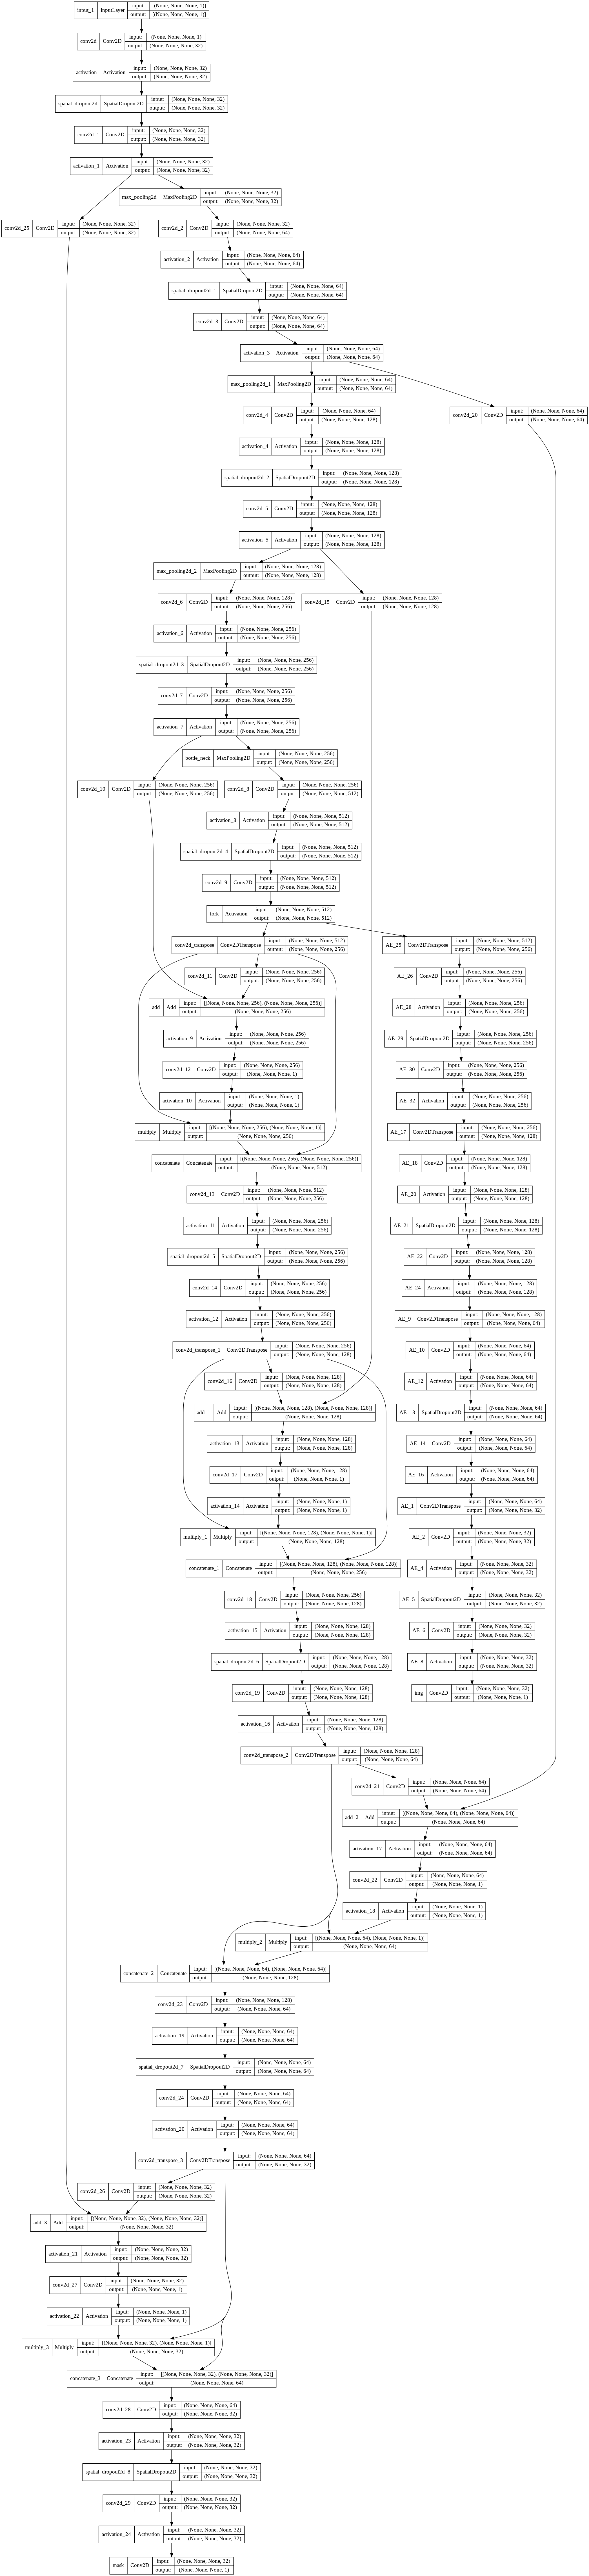

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Train model

In [112]:
history = model.fit(train_generator2, validation_data=val_generator2,
                    validation_steps=np.ceil(val_data_size/batch_size_value),
                    steps_per_epoch=np.ceil(train_data_size/batch_size_value),
                    epochs=numEpochs, callbacks=callbacks)

Epoch 1/100
900/900 [==============================] - 45s 47ms/step - loss: 0.2561 - img_loss: 0.0033 - mask_loss: 0.2561 - mask_new_jaccard: 0.0743 - val_loss: 0.1249 - val_img_loss: 0.0045 - val_mask_loss: 0.1249 - val_mask_new_jaccard: 0.2964
Epoch 2/100
900/900 [==============================] - 42s 46ms/step - loss: 0.1487 - img_loss: 0.0035 - mask_loss: 0.1487 - mask_new_jaccard: 0.1887 - val_loss: 0.0969 - val_img_loss: 0.0047 - val_mask_loss: 0.0969 - val_mask_new_jaccard: 0.4100
Epoch 3/100
900/900 [==============================] - 42s 46ms/step - loss: 0.1196 - img_loss: 0.0036 - mask_loss: 0.1196 - mask_new_jaccard: 0.2898 - val_loss: 0.0815 - val_img_loss: 0.0050 - val_mask_loss: 0.0815 - val_mask_new_jaccard: 0.4726
Epoch 4/100
900/900 [==============================] - 41s 46ms/step - loss: 0.1006 - img_loss: 0.0038 - mask_loss: 0.1006 - mask_new_jaccard: 0.3665 - val_loss: 0.0667 - val_img_loss: 0.0052 - val_mask_loss: 0.0667 - val_mask_new_jaccard: 0.5174
Epoch 5/100


Plot loss - IoU

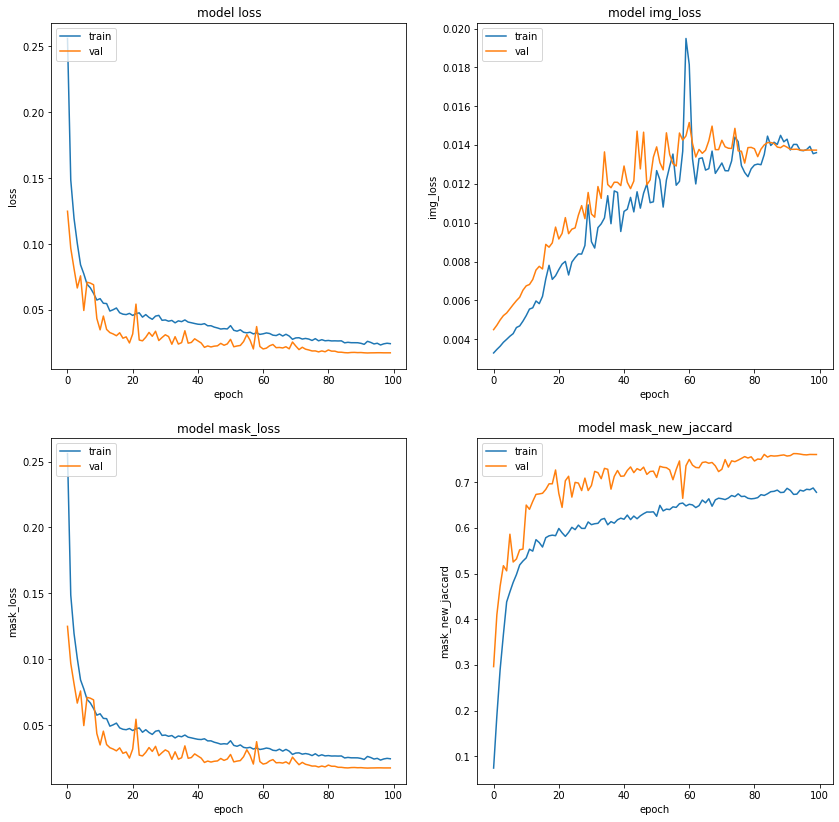

In [113]:
metrics = [
    'loss',
    'img_loss',
    'mask_loss',
    #'img_mean_squared_error',
    'mask_new_jaccard'
    ]
plot_loss_and_metric(metrics, history)

### Save weights

In [ ]:
# Save weights for future reuse
if schedule is None:
    schedule = 'None'
create_dir(out_dir)
out_name = 'weights-{}-src-{}-trg-{}-mse-{}-bce-{}-nf-{}-bs-{}-{}-{}.h5'.format(
                                            model_name, source, target, alpha,
                                            beta, num_filters, batch_size_value,
                                            optimizer_name, schedule )
weights_filename = os.path.join(out_dir, out_name)
model.save_weights( weights_filename )
print( 'Saved model as ' + weights_filename )

## Evaluation
\+ display examples

In [32]:
from sklearn.metrics import mean_squared_error
from copy import copy

# delete data variables used for training. Save RAM
del (target_trainTest_img, source_img, source_lbl,
target_img, target_lbl, source_test_img,
source_test_lbl, target_test_img, target_test_lbl)

def evaluation(path):
    '''
    Evaluate the model on the test set and print the results and some examples
    
    Args:
      path: Path to the folder containing the test images.
    '''
    original_test_img, original_test_lbl = get_xy_image_list(path)
    #display([test_img[0], test_lbl[0]])

    test_img = copy(original_test_img)
    test_lbl = copy(original_test_lbl)
    test_img = [add_padding(x) for x in test_img]
    test_lbl = [add_padding(x) for x in test_lbl]

    # Prepare the test data
    X_test = [x/255 for x in test_img] # normalize between 0 and 1
    X_test = np.expand_dims( np.asarray(X_test, dtype=np.float32), axis=-1 ) # add extra dimension
    Y_test = [x/255 for x in test_lbl] # normalize between 0 and 1
    Y_test = np.expand_dims( np.asarray(Y_test, dtype=np.float32), axis=-1 ) # add extra dimension
    del test_img, test_lbl # save ram
    
    # Now, we calculate the final test metrics (custom_eval)
    reconst_test, preds_test = model.predict(X_test, batch_size=batch_size_value)

    pred_masks = preds_test[:,:,:,0]>=0.5
    pred_masks = [remove_padding(pred_masks[i], x.shape) for i, x in enumerate(original_test_lbl)] # remove padding
    pred_reconst = [remove_padding(reconst_test[i][:,:,0], x.shape) for i, x in enumerate(original_test_img)] # remove padding
    del reconst_test, preds_test
    Y_test_noPadd = [remove_padding(Y_test[i][:,:,0], x.shape) for i, x in enumerate(original_test_lbl)] # remove padding
    X_test_noPadd = [remove_padding(X_test[i][:,:,0], x.shape) for i, x in enumerate(original_test_img)] # remove padding


    iou = []
    mse = []
    for i in range(0, len(pred_masks)):
        iou.append( jaccard_index(Y_test_noPadd[i], pred_masks[i]) )
        mse.append( mean_squared_error(X_test_noPadd[i], pred_reconst[i]) ) 
    mean_iou = np.mean(iou)
    mean_mse = np.mean(mse)

    print("\nTest MSE:", mean_mse)
    print("Test IoU:", mean_iou)

    show_predictions_multitask(X_test, Y_test, num=2)


Source

Input images loaded: 75 -- Label images loaded: 75
	path: /content/mitochondria/Kasthuri++/test

Test MSE: 0.009516754
Test IoU: 0.8744915473880905


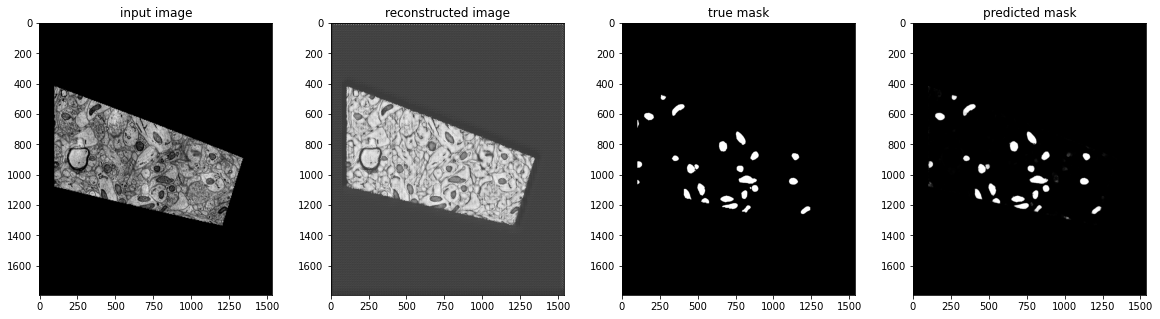

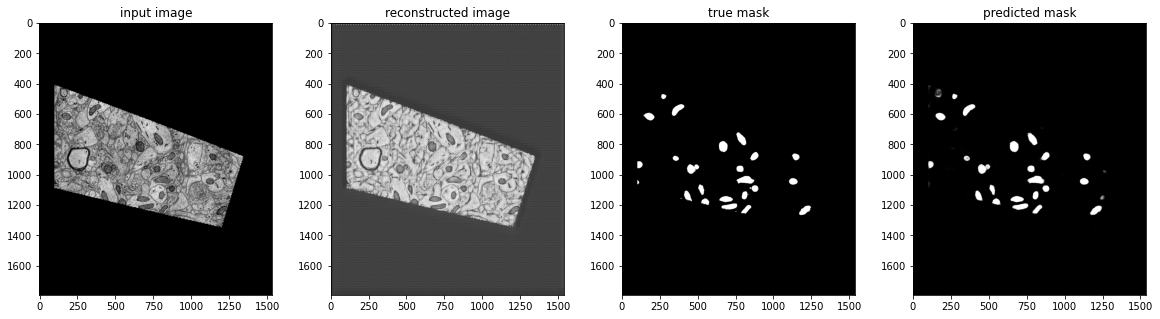

In [33]:
evaluation(source_test_data_path) # + display examples

Target

Input images loaded: 165 -- Label images loaded: 165
	path: /content/mitochondria/Lucchi++/test

Test MSE: 0.009049233
Test IoU: 0.7329855613945244


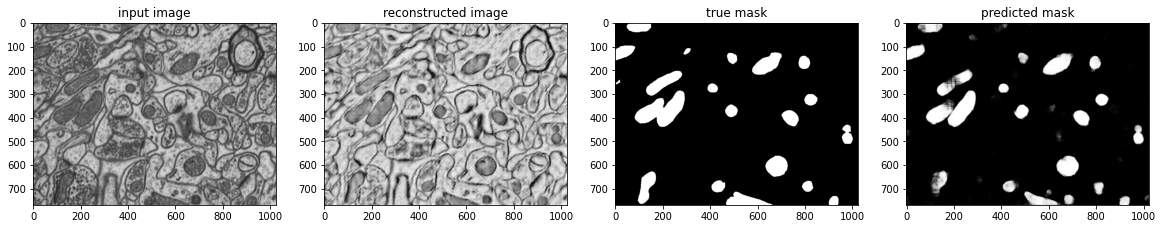

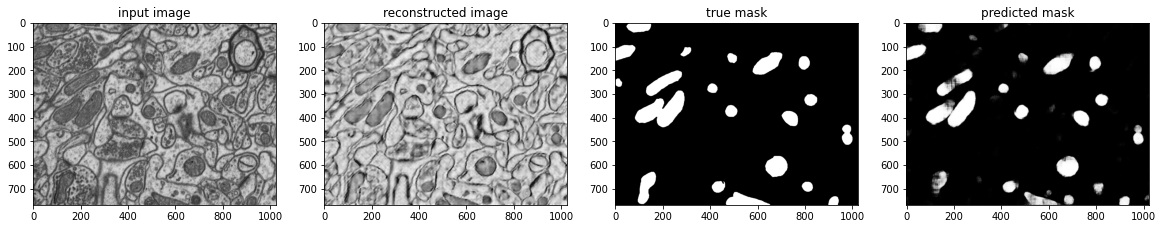

In [34]:
evaluation(target_test_data_path) # + display examples